### [ data augumentation]
- 要先對資料做 train/test split 後再做資料增強，否則其實都是同樣的影像
- 資料增強應該要在圖像標準化之前完成 (e.g. 除以 255、減去平均值)，因為多數資料增強的函數多是以圖像為 int32 的 RGB 影像來來設計的，若已經先經過標準化，有可能造成程式碼錯誤

- 可使⽤ [Keras ](https://zhuanlan.zhihu.com/p/30197320)內建的資料增強函數，或是使⽤開源的 [imgaug](https://github.com/aleju/imgaug) 來完成更多特殊的資料增強⽅法

In [1]:
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

Using TensorFlow backend.
C:\Users\admin\Anaconda3\envs\tf\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\admin\Anaconda3\envs\tf\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\admin\Anaconda3\envs\tf\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\admin\Anaconda3\envs\tf\lib\site-packages\tenso

In [2]:
# 此函數會幫我們把多張影像畫成一張多宮格圖
def img_combine(img, ncols=8, size=1, path=False):
    from math import ceil
    import matplotlib.pyplot as plt
    import numpy as np
    nimg = len(img)
    nrows = int(ceil(nimg/ncols))
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(ncols*size,nrows*size))
    if nrows == 0:
        return
    elif ncols == 1:
        for r, ax in zip(np.arange(nrows), axes):
            nth=r
            if nth < nimg:
                ax.imshow(img[nth], cmap='rainbow', vmin=0, vmax=1)
                
            ax.set_axis_off()
    elif nrows == 1:
        for c, ax in zip(np.arange(ncols), axes):
            nth=c
            if nth < nimg:
                ax.imshow(img[nth], cmap='rainbow', vmin=0, vmax=1)
            ax.set_axis_off()
    else:
        for r, row in zip(np.arange(nrows), axes):
            for c, ax in zip(np.arange(ncols), row):
                nth=r*ncols+c
                if nth < nimg:
                    ax.imshow(img[nth], cmap='rainbow', vmin=0, vmax=1)
                ax.set_axis_off()
    plt.show()

In [3]:
# 讀取 Cifar-10 資料集
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

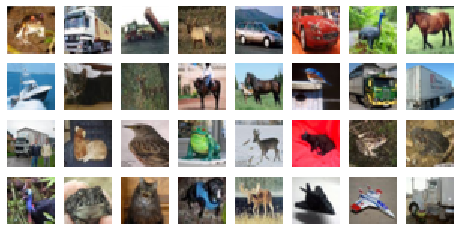

In [4]:
# 取前 32 張圖片做視覺化
images = x_train[:32]
img_combine(images)

In [5]:
# 建立 ImageDataGenerator，並指定我們要做資料增強的數值範圍
data_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

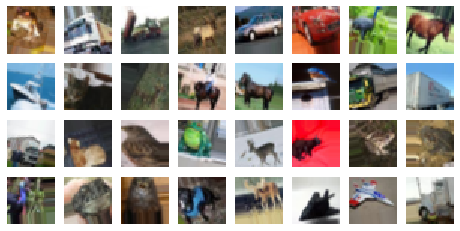

In [6]:
# 注意！！ ImageDataGenerator 是一個 Generator (生成器)! 對 Generator 不熟悉的同學請回到 Day098 做複習。
# 使用 .flow 後，就會對我們的影像進行增強，再 call next 取出 generator 的圖像。(shuffle=False 因為我們希望圖像的順序不要改變，方便觀察。實際訓練時預設是 shuffle=True) 
augmented_iamges = next(data_generator.flow(images, shuffle=False))
img_combine(augmented_iamges.astype("int")) # 注意在訓練時神經網路時，圖像資料必須要是 float32，但在做視覺化時要轉為 int 才能順利畫圖。所以為了畫圖才把資料轉為 int

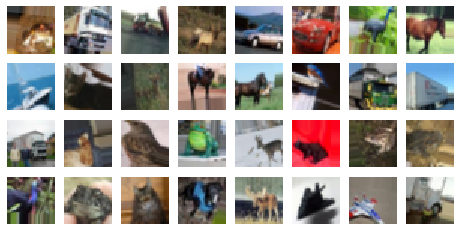

In [7]:
# 因為隨機性的關係，所以一樣的圖像再經過一次 generator 後的結果不一定相同
augmented_iamges = next(data_generator.flow(images, shuffle=False))
img_combine(augmented_iamges.astype("int"))

## [ 作業 ]

請使用 ImageDataGenerator 來進行 Cifar-10 資料集的訓練，並觀察不同的圖像增強方法是否會顯著影響訓練結果

In [8]:
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import RMSprop, Adam

### data preprocessing

In [28]:
batch_size = 128 
num_classes = 10 
epochs = 10 

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


### create model

In [29]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_13 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_14 (Activation)   (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 15, 15, 64)       

### ImageDataGenerator

In [30]:
# 建立 ImageDataGenerator，並指定我們要做資料增強的數值範圍
data_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

augmented_iamges = next(data_generator.flow(images, shuffle=True))

### train model

In [32]:
history = model.fit_generator(data_generator.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=int(len(x_train)/batch_size), # 一個 epochs 要執行幾次 update，通常是資料量除以 batch size
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
390/390 [==============================] - 243s 624ms/step - loss: 1.9085 - accuracy: 0.2973 - val_loss: 1.4765 - val_accuracy: 0.4561
Epoch 2/10
390/390 [==============================] - 235s 602ms/step - loss: 1.6099 - accuracy: 0.4183 - val_loss: 1.4237 - val_accuracy: 0.4821
Epoch 3/10
390/390 [==============================] - 233s 597ms/step - loss: 1.4590 - accuracy: 0.4740 - val_loss: 1.1315 - val_accuracy: 0.5959
Epoch 4/10
390/390 [==============================] - 236s 606ms/step - loss: 1.3599 - accuracy: 0.5127 - val_loss: 1.0556 - val_accuracy: 0.6217
Epoch 5/10
390/390 [==============================] - 238s 611ms/step - loss: 1.2881 - accuracy: 0.5398 - val_loss: 1.2090 - val_accuracy: 0.5732
Epoch 6/10
390/390 [==============================] - 233s 597ms/step - loss: 1.2336 - accuracy: 0.5626 - val_loss: 0.9887 - val_accuracy: 0.6574
Epoch 7/10
390/390 [==============================] - 233s 598ms/step - loss

### 使用不同的圖像增強方法

In [34]:
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

# data augmentation
data_generator = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.4,
    height_shift_range=0.4,
    horizontal_flip=True)

augmented_iamges = next(data_generator.flow(images, shuffle=True))

# train model
history = model.fit_generator(data_generator.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=int(len(x_train)/batch_size), # 一個 epochs 要執行幾次 update，通常是資料量除以 batch size
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/10
390/390 [==============================] - 231s 593ms/step - loss: 1.2992 - accuracy: 0.5540 - val_loss: 1.2145 - val_accuracy: 0.6058
Epoch 2/10
390/390 [==============================] - 231s 592ms/step - loss: 1.2950 - accuracy: 0.5511 - val_loss: 1.1286 - val_accuracy: 0.6329
Epoch 3/10
390/390 [==============================] - 231s 591ms/step - loss: 1.2772 - accuracy: 0.5583 - val_loss: 1.0177 - val_accuracy: 0.6621
Epoch 4/10
390/390 [==============================] - 231s 593ms/step - loss: 1.2839 - accuracy: 0.5577 - val_loss: 1.0841 - val_accuracy: 0.6520
Epoch 5/10
390/390 [==============================] - 230s 591ms/step - loss: 1.2838 - accuracy: 0.5574 - val_loss: 1.0631 - val_accuracy: 0.6279
Epoch 6/10
390/390 [==============================] - 230s 591ms/step - loss: 1.2838 - accuracy: 0.5567 - val_loss: 1.2346 - val_accuracy: 0.6370
Epoch 7/10
390/390 [==============================] - 231s 591ms/step - loss: 1.2910 - accuracy: 0.5556 - val_loss: 1.0908 -